In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


# Bayesian Hypothesis Testing

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``

# Reference for Bayesian t-test


> Kruschke J, **Doing Bayesian Data Analysis**, Ch. 12

# Drug trial evaluation

* We  want to  evaluate  of a drug that is supposed to increase intelligence.

* We have IQ measures  of:
    * 47 individuals receiving the drug  (treatment group)
    * 42 individuals  receiving the placebo (control group). 
    
* Some observations are however far from the mean.

In [2]:
iq_drug = np.array ([101,100,102,104,105,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,104,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,103,103,100,101,103,104,100,101])
iq_placebo = np.array ([ 99,101,100,101,99,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,98,99])



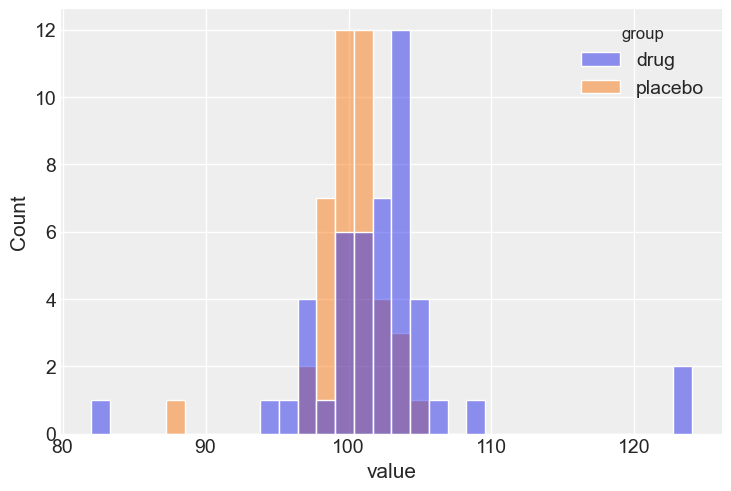

In [3]:
y  = pd.DataFrame(dict(value=np.r_[iq_drug, iq_placebo], group=np.r_[['drug']*len(iq_drug), ['placebo']*len(iq_placebo)]))
sns.histplot(data=y, x="value", hue="group");

# Research question

* The sample mean of the drug group  is superior, but:

    * there is a lot of variability within groups
    * there are some outliers.



* Is the drug credibly associated to a higher  IQ? 

# Research question

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_1$, $\bar{y}_2$) 

    * sample standard deviations ($s_1, s_2$) 

    * numerosity ($n_1, n_2$)


* The sample are drawn from two populations with (unknown) parameters $\mu_1, \mu_2, \sigma_1, \sigma_2$.


* Which conclusion can we make about  $\mu_2 >  \mu_1$?

# Main idea

* We will fit a normal-normal model on each group.


* Eventually we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}


# Background information 

* The IQ can be interpreted according to the <a href="https://www.123test.com/interpretation-of-an-iq-score/"> IQ scale meaning </a>.

    * its  mean in the population is  about 100
    * the IQ is generally assumed to be normally distributed. 
    *  extreme values of IQ  are 60 ( cognitively impaired) and 140 (gifted). 
    * a plausible value of standard devation is about  20 , obtained as  $\sigma$= (100 - 60)/2 = (140-100)/2



# Prior for $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$

* We assign a normal prior to both means.


* The mean IQ of the population is 100 and extreme values of IQ are 60 and 140.


* The  mean IQ of the population could lie in (80, 120). Thus:

$$
\mu_{\text{drug}}   \sim  N (100, 10 )
$$
$$
\mu_{\text{placebo}}   \sim  N (100, 10 )
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



In [4]:
#Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 20.
from scipy.stats import halfnorm
# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=30, size=10000)).describe()

,0
count,10000.000000
mean,24.089939
std,18.145484
min,0.004981
25%,9.808766
50%,20.401381
75%,34.519428
max,114.781916


## Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$y_{drug} \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}})$$

$$y_{placebo} \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})$$

where $y$ are the observations in each group.



#  The probabilistic model

\begin{align*}
\mu_{\text{drug}} & \sim N(100,10) \\
\sigma_{\text{drug}} & \sim \text{half-normal} (30) \\
y_{\text{drug},i}  & \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}}) \\
\\
\mu_{\text{placebo}} & \sim N(100,10) \\
\sigma_{\text{placebo}} & \sim \text{half-normal} (30) \\
y_{\text{placebo},i}  & \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})\\
\end{align*}


# Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can define it   as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have its posterior samples in the trace.

In [5]:

with pm.Model() as  normal_model:
    mu_drug              = pm.Normal         ('mu_drug',          mu = 100,  sd = 10)
    mu_placebo        = pm.Normal          ('mu_placebo',    mu = 100,  sd = 10)
    sigma_drug         = pm.HalfNormal ('sigma_drug',      sigma=30)
    sigma_placebo   = pm.HalfNormal ('sigma_placebo', sigma=30)

    
    #likelihood for the two groups
    y_drug         = pm.Normal  ('y_1',  mu=mu_drug,      sigma=sigma_drug,       observed= iq_drug)
    y_placebo   = pm.Normal  ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= iq_placebo)
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_drug - mu_placebo)


In [6]:
with normal_model:
    normal_trace    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo, sigma_drug, mu_placebo, mu_drug]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


# Checking convergence

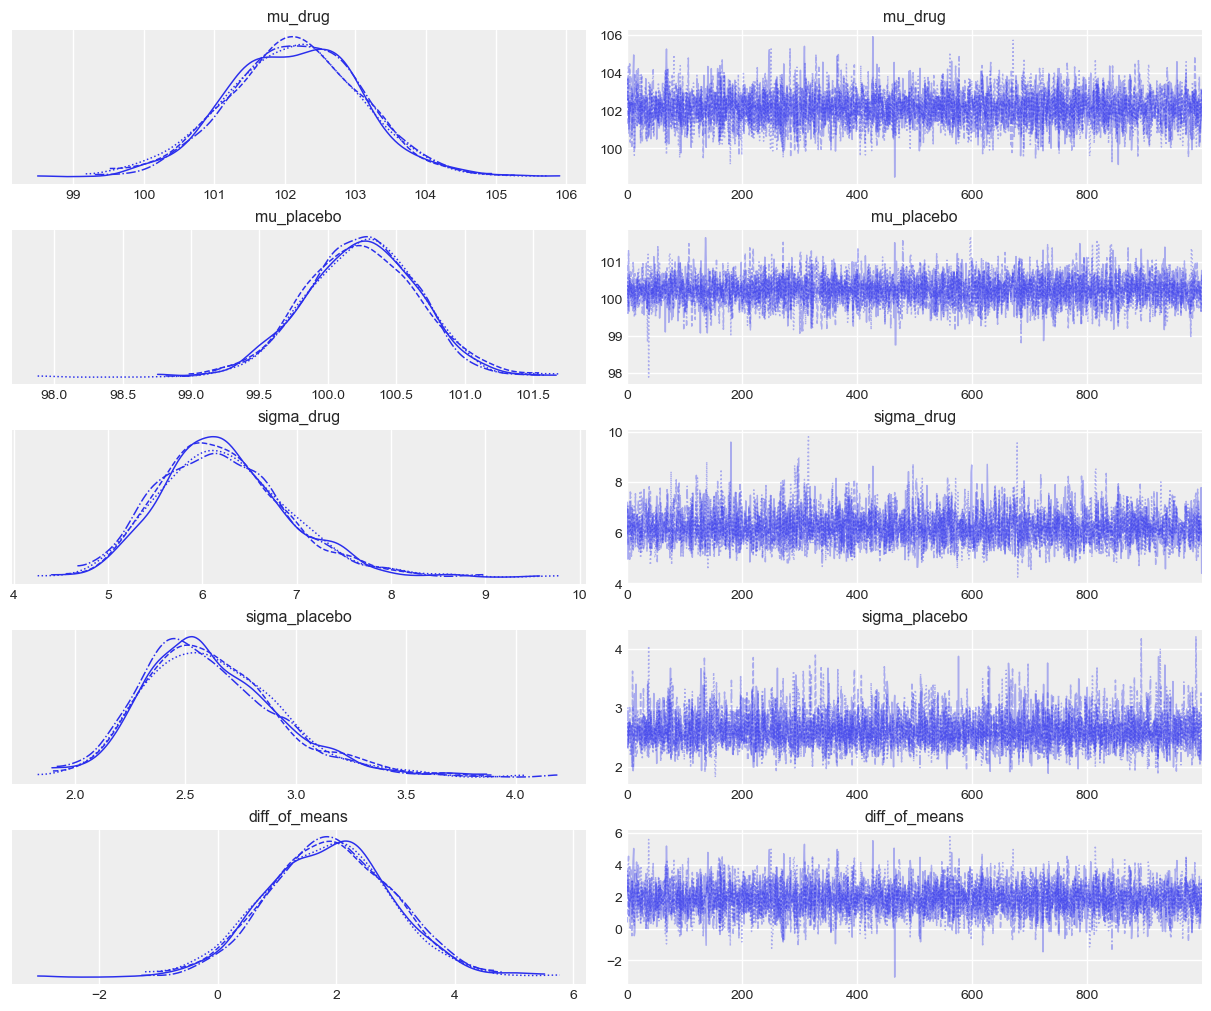

In [7]:
az.plot_trace(normal_trace);

In [8]:
az.summary(normal_trace,  hdi_prob=0.90)
#the 90% hdi of the difference between the two means includes only positive values. 
#With 90% probability we can conclude that the drug is associated to a higher IQ.

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug,102.133,0.943,100.570,103.636,0.013,0.009,5152.0,2850.0,1.0
mu_placebo,100.247,0.410,99.556,100.883,0.006,0.004,5081.0,3223.0,1.0
sigma_drug,6.220,0.674,5.186,7.351,0.009,0.007,5761.0,3138.0,1.0
sigma_placebo,2.619,0.312,2.119,3.099,0.004,0.003,5788.0,3052.0,1.0
diff_of_means,1.886,1.035,0.232,3.614,0.014,0.011,5182.0,2729.0,1.0


# Posterior predictive checks

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


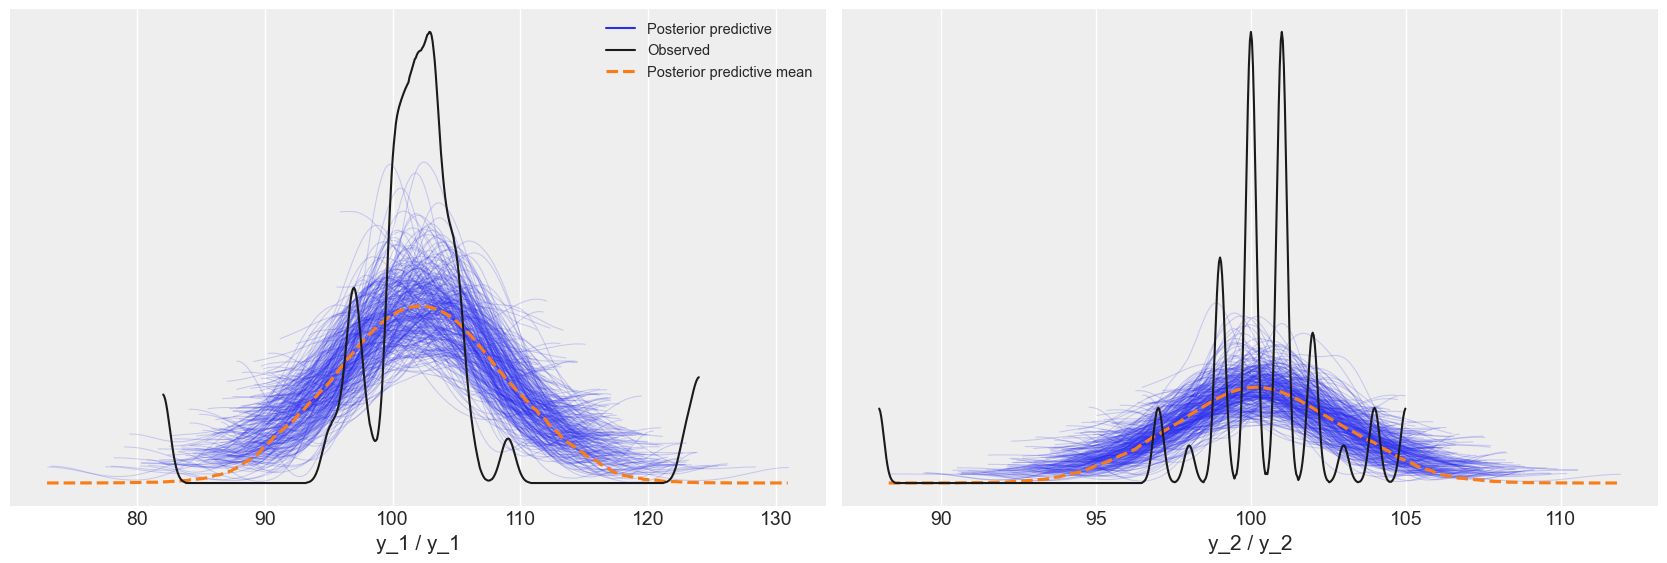

In [9]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with normal_model:
     ppc = pm.sample_posterior_predictive(normal_trace, samples=300)
    
# The density is too low in the bulk of the distribution, for both groups. 
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=normal_model));

# Discussion
* The density is too low in the center of the distribution.
* For the moment, we continue the analysis with our current model.
* Later we will refine the model.


# Analyzing the posterior of the difference
* We can assess the credibility of the hypothesis $\mu_1 - \mu_2 = 0$.


* This is the hypothesis of  the mean IQ being the same in the two groups. 


*  We thus  examine the posterior distribution of  $\mu_1 - \mu_2$  and we will check  whether 0  falls in a region of high density or not.


* If the null value is far from the most credible values, we  reject it.

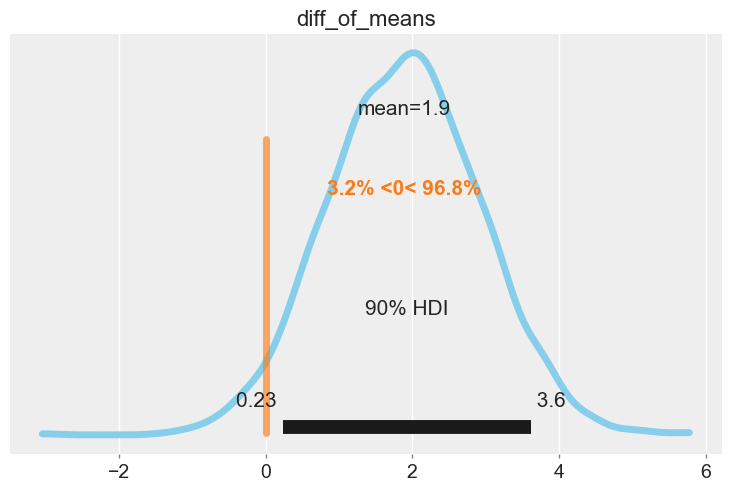

In [10]:
az.plot_posterior(normal_trace, var_names=['diff_of_means'],  ref_val=0, color='#87ceeb', linewidth=5, hdi_prob=0.9);

# Discussion


*  The 90 % HDI of the difference of means falls well above zero, and about 97% of the credible values are greater than zero. 


* Thus the groups’ means are credibly different and we reject with probability 90% the  value of 0.


* Usually however  higher credibility are required (95% or 99%), in which case we are no longer rejecting the hypothesis.


* As a more informative approach, we could define some intervals on the difference and compute the posterior probability of each interval.


## Robust likelihood

* We now adopt   a Student-t distribution to describe the distributions of the scores in each group. 



* We use a Student-t distribution with 4 degrees of freedom.



* The likelihood functions of our models become:

$$y_{\text{drug},i} \sim StudentT(\mu_{\text{drug}}, \sigma_{\text{drug}}, \nu=4)$$

$$y_{\text{placebo},i} \sim StudentT(\mu_{\text{placebo}}, \sigma_{\text{placebo}},  \nu=4)$$


In [11]:
with pm.Model() as student_model:
    #prior are  unchanged.
    mu_drug_t              = pm.Normal         ('mu_drug_t',          mu = 100,  sd = 5)
    mu_placebo_t        = pm.Normal          ('mu_placebo_t',    mu = 100,  sd = 5)
    sigma_drug_t         = pm.HalfNormal ('sigma_drug_t',      sigma=25)
    sigma_placebo_t    = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    #But now we adopt a robust likelihood. 
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model more complex to sample. 
    y_drug = pm.StudentT ('y_drug',       nu=4, mu=mu_drug_t,       sd=sigma_drug_t,       observed= iq_drug)
    y_placebo = pm.StudentT ('y_placebo', nu=4, mu=mu_placebo_t,  sd=sigma_placebo_t, observed= iq_placebo)
    
    #Derived quantities:
    diff_of_means_t = pm.Deterministic('diff_of_means', mu_drug_t - mu_placebo_t)
    student_trace    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo_t, sigma_drug_t, mu_placebo_t, mu_drug_t]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


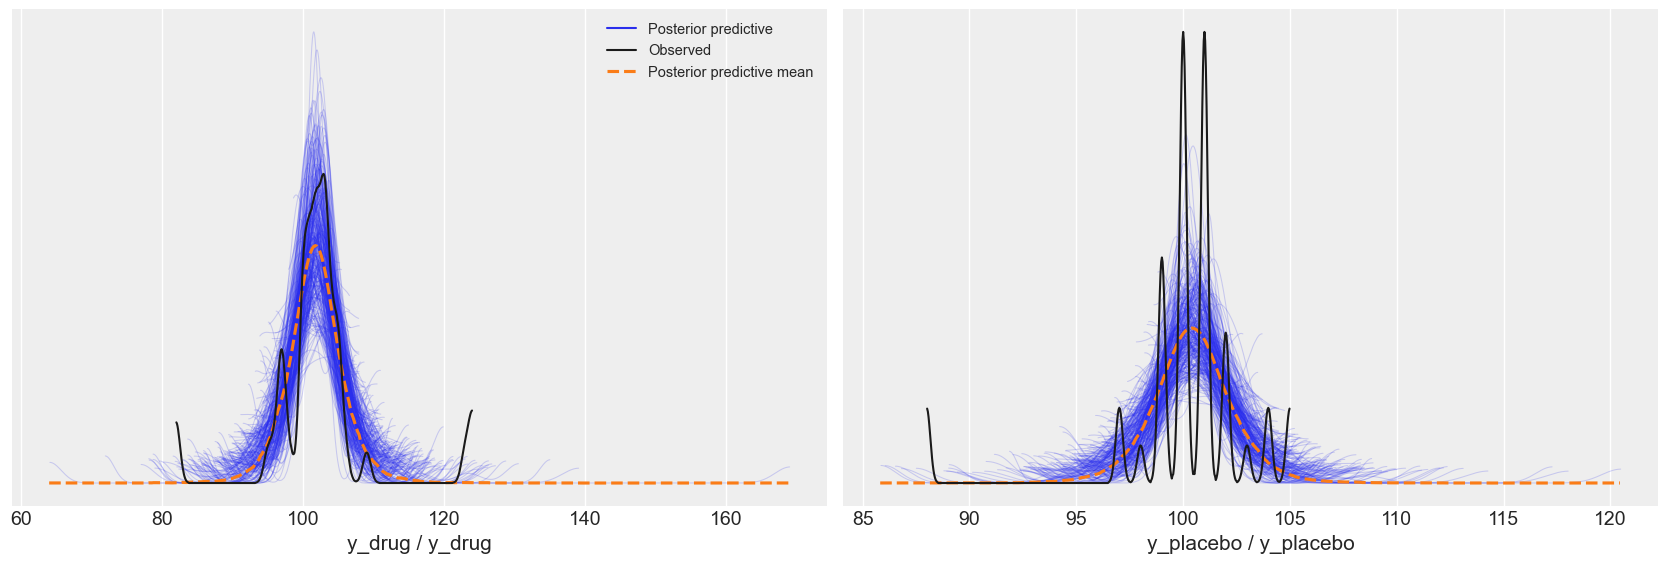

In [12]:
#the fit is better compare to the normal model, though not yet perfect for the placebo group.
with student_model:
    ppc_t = pm.sample_posterior_predictive(student_trace, samples=300)
    az.plot_ppc(az.from_pymc3(posterior_predictive=   ppc_t, model= student_model));

In [13]:
# the sigma decreases by almost a half compared to the Gaussian model, as the student distribution filters outliers.
# as a results, the hdi become shorter, and the amount of difference between the two groups becomes clearer.
pd.concat( [az.summary(student_trace,  hdi_prob=0.9), az.summary(normal_trace, hdi_prob=0.9) ])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug_t,101.801,0.501,100.962,102.590,0.007,0.005,5720.0,2898.0,1.0
mu_placebo_t,100.434,0.254,99.999,100.828,0.003,0.002,6011.0,3056.0,1.0
sigma_drug_t,3.000,0.467,2.192,3.700,0.006,0.005,5688.0,3265.0,1.0
sigma_placebo_t,1.411,0.224,1.032,1.744,0.003,0.002,5119.0,2999.0,1.0
diff_of_means,1.366,0.571,0.452,2.279,0.007,0.006,5935.0,3166.0,1.0
mu_drug,102.133,0.943,100.570,103.636,0.013,0.009,5152.0,2850.0,1.0
mu_placebo,100.247,0.410,99.556,100.883,0.006,0.004,5081.0,3223.0,1.0
sigma_drug,6.220,0.674,5.186,7.351,0.009,0.007,5761.0,3138.0,1.0
sigma_placebo,2.619,0.312,2.119,3.099,0.004,0.003,5788.0,3052.0,1.0
diff_of_means,1.886,1.035,0.232,3.614,0.014,0.011,5182.0,2729.0,1.0


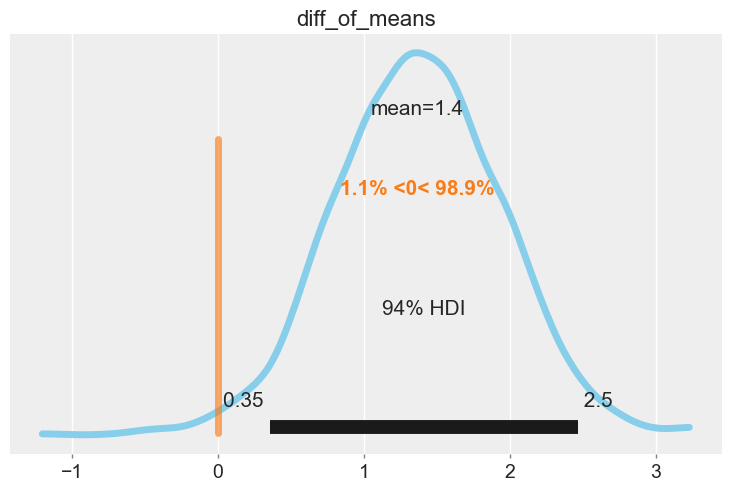

In [14]:
# the significance of the difference between the two groups is now stronger
az.plot_posterior(student_trace, var_names=['diff_of_means'],  ref_val=0, color='#87ceeb', linewidth=5);

# Exercise: effect size

A further indicator used to  compare the means of the two populations is *effect size* (Cohen's $d$):

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sigma_P}$$ 

where  $\sigma_P$ is the pooled standard deviation,  $\sigma_P = \sqrt{ \frac{\sigma_2^2 + \sigma_1^2}{2} }$

* Effect size is  the amount of change induced by the treatment relative to the standard deviation. It is often used in medical studies.


* Compare the two groups by using this indicator.

# Exercise : effect size

* Compute the posterior probability of the effect size being small, medium or large:

    * small  effect ($0 \leq d \leq 0.5$)

    * medium effect  ($0.5 \leq d \leq 1$)

    * large  effect ($d >  1$)

* Negative values of $d$ can be interpreted likewise.


* Hints:

    * define `effect_size` as a deterministic variable of the model.

    * use `d  = az.extract_dataset(trace, var_names="effect_size")` to access the values of effect size from the trace.

# Exercise 2: analyze a case study

* An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients. 


* A group of patients was randomly assigned to treatment and control groups.


* Out of 674 patients receiving the control, 39 died, and out of 680 receiving the treatment, 22 died. 

* Assume that the outcomes are independent and binomially distributed, with probabilities of death of $p_0$ and $p_1$ under the control and treatment, respectively. Set up a noninformative or weakly informative prior distribution on ($p_0$, $p_1$).


* Formulate (1) model likelihood,  prior and   posterior.

* Summarize the posterior distribution for the odds ratio, (p1/(1 − p1))/(p0/(1 − p0)). Compute the point estimate, a posterior interval (95%), and draw your conclusions. 